# Problem Statement
## Context
Some banking institutions use marketing campaigns to make clients subscribe to their services. One of those services is the term deposit, which restricts withdrawing the deposit until the term ends. This deposit allows a higher flexibility in budget management because it doesn't affect the "liquidity coverage ratio" (the amount of money that the bank has to be able to pay instantly). Therefore, predicting and identifying customers who are prone to subscribe to term deposits is beneficial.

## Goal
The goal is to predict what type of customers will probably subscribe to term deposits by answering the following questions:
* What kind of customers usually subscribe to term deposits?
* By adjusting which marketing parameters banking insitution can increase chances of subscription?
* What type of customers marketing team should focus on for their next marketing campaign?

# Data Collection
## Data Source
I used "Bank Marketing" dataset from Kaggle provided by user Henrique Yamahata. [https://www.kaggle.com/henriqueyamahata/bank-marketing?select=bank-additional-full.csv]

## Data description

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disabling autoscrolling for long graphs*/

<IPython.core.display.Javascript object>

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('bank-additional-full.csv', sep = ';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Attributes can be divided into the following groups:

### Client data:
* Age (numeric)
* Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
* Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
* Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
* Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Current campaign
* Contact: last contact communication type (categorical: 'cellular','telephone')
* Month: last contact month of year (categorical: 'jan', 'feb', 'mar',…, 'nov', 'dec')
* Dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no').
* Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Previous campaign 
* Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* Previous: number of contacts performed before this campaign and for this client (numeric)
* Poutcome: outcome of the previous marketing campaign (categorical:'failure','nonexistent','success')

### Social and economic context attributes
* Emp.var.rate: employment variation rate - quarterly indicator (numeric)
* Cons.price.idx: consumer price index - monthly indicator (numeric)
* Cons.conf.idx: consumer confidence index - monthly indicator(numeric)
* Euribor3m: euribor 3 month rate - daily indicator (numeric)
* Nr.employed: number of employees - quarterly indicator (numeric)

### Output variable
* y - has the client subscribed a term deposit? (binary: 'yes', 'no')

# Exploratory Data Analysis
## 1. Understanding Client data
For more convenient use I will create new DataFrame with only Client data.

In [4]:
#Selecting client related columns
client_data = data.iloc[:, :7]
#Adding 'y'
client_data = pd.concat([client_data, data.y], axis = 1)
client_data.head()

age        job  marital    education  default housing loan   y
0   56  housemaid  married     basic.4y       no      no   no  no
1   57   services  married  high.school  unknown      no   no  no
2   37   services  married  high.school       no     yes   no  no
3   40     admin.  married     basic.6y       no      no   no  no
4   56   services  married  high.school       no      no  yes  no

### Univariate Analysis
I will plot several graphs of distribution of each variable so we can derive useful insights about client data.

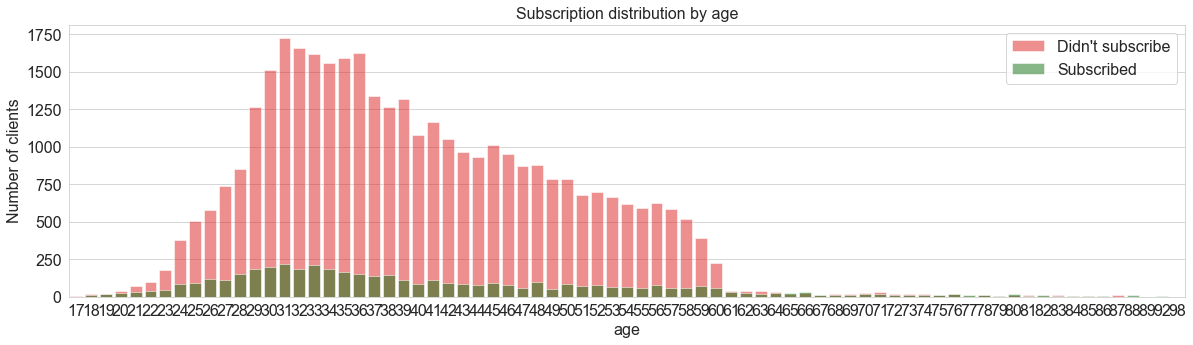

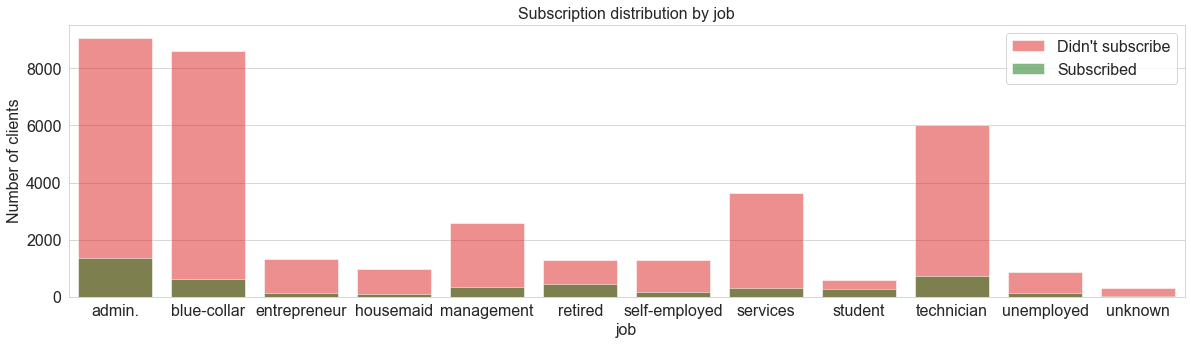

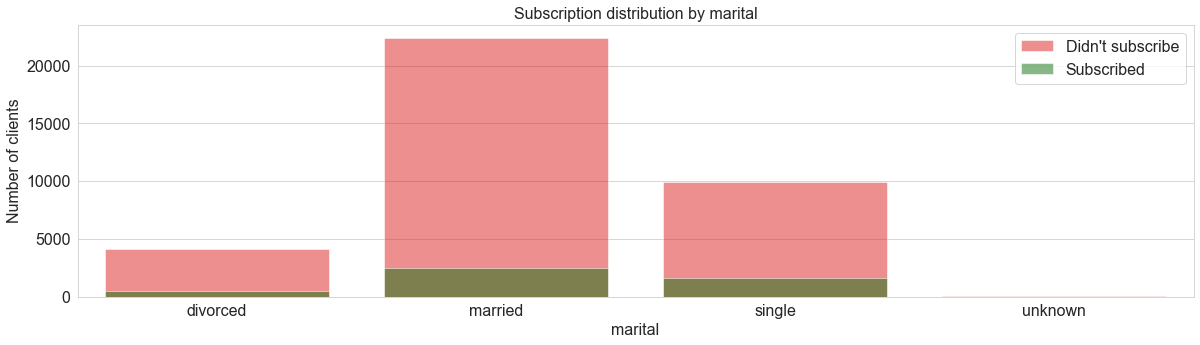

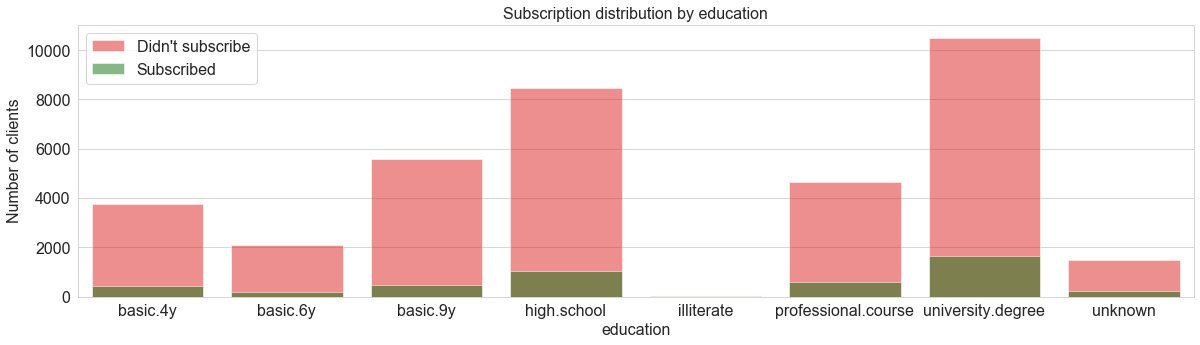

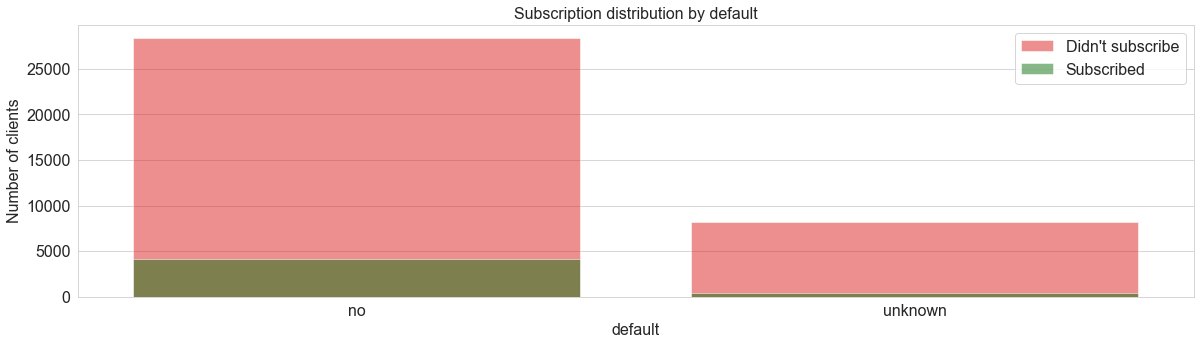

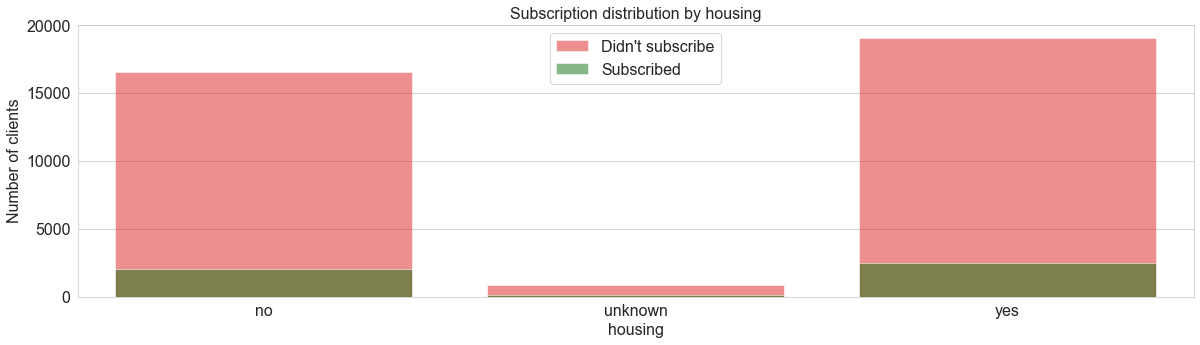

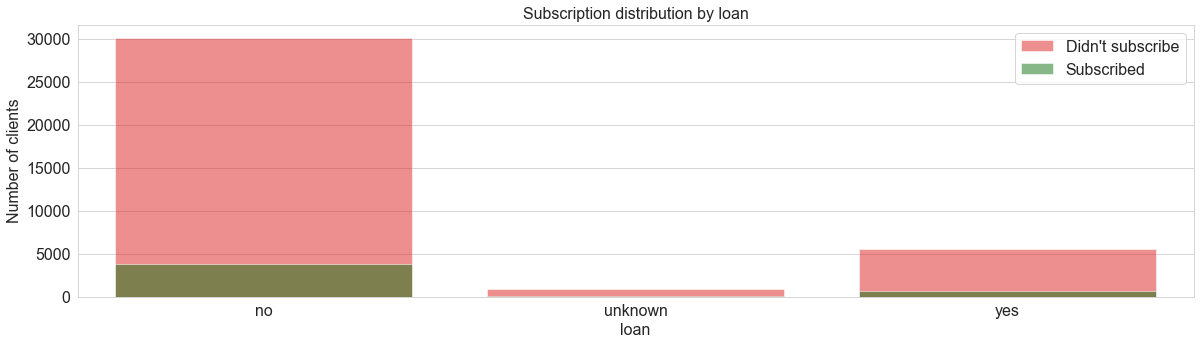

In [5]:
sns.set_style("whitegrid")
for column in client_data.columns[:-1]:
    #Comparing subscribtion composition of each age
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    sns.countplot(x = column, data = client_data[client_data.y == 'no'].sort_values(by = [column]), label="Didn't subscribe", color = 'red', alpha = 0.5)
    sns.countplot(x = column, data = client_data[client_data.y == 'yes'].sort_values(by = [column]), label="Subscribed", color = 'green', alpha = 0.5)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Number of clients', fontsize=16)
    ax.set_title("Subscription distribution by " + column, fontsize=16)
    ax.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    plt.show()

**I will also plot graphs of campaign efficiency by columns.**

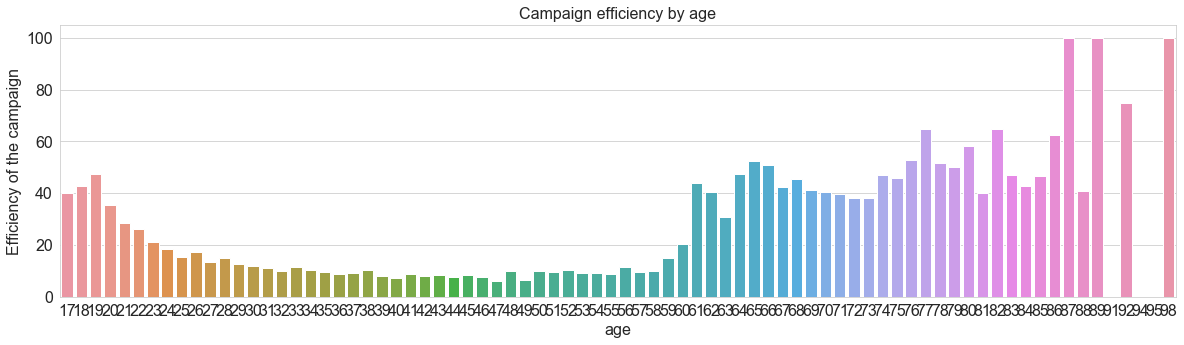

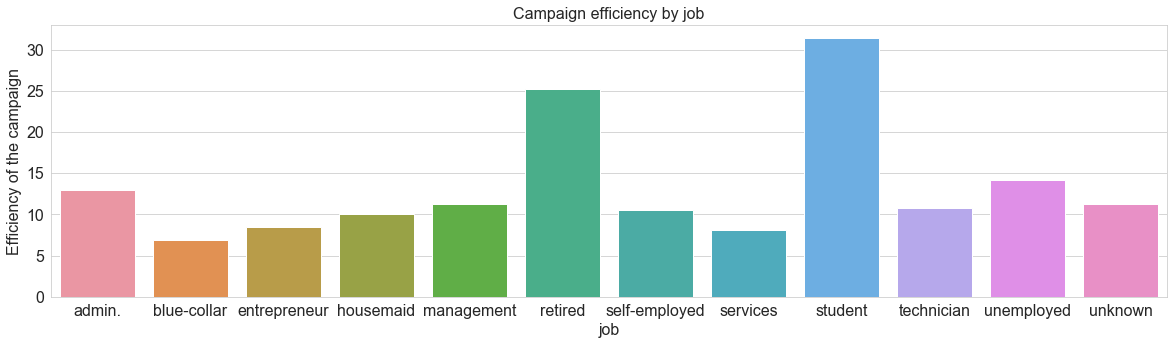

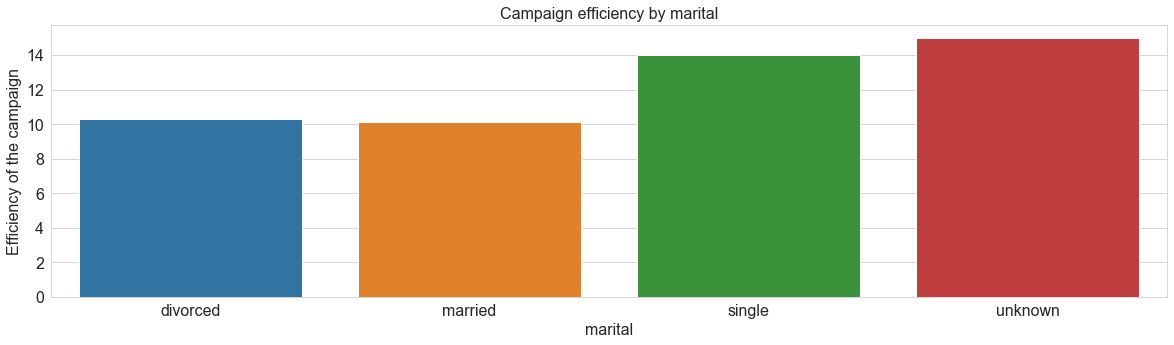

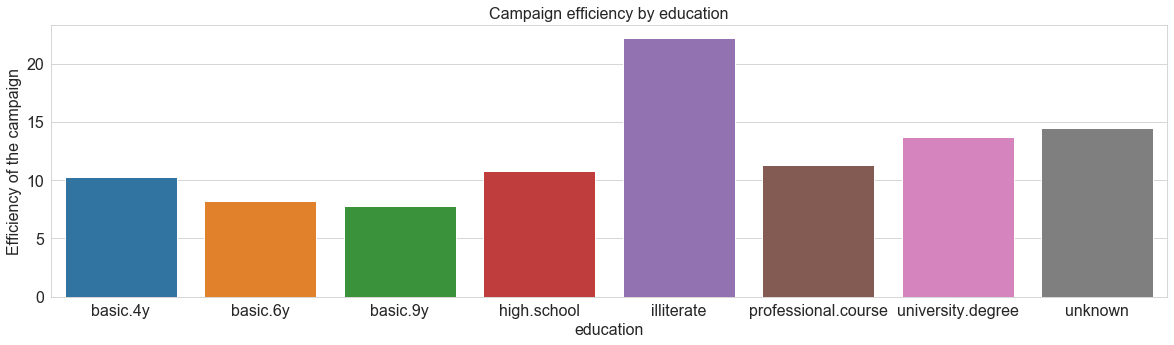

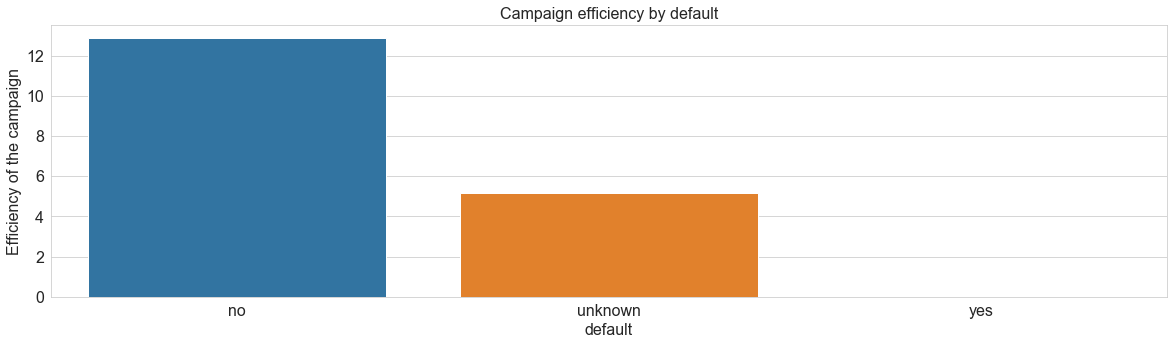

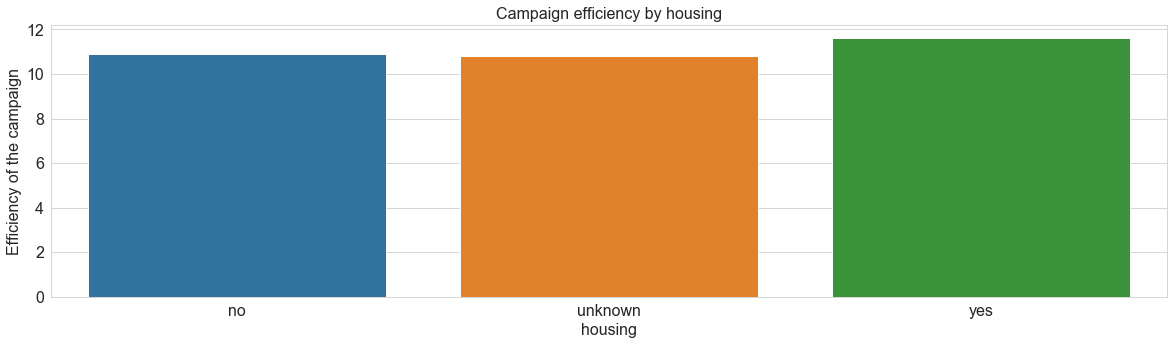

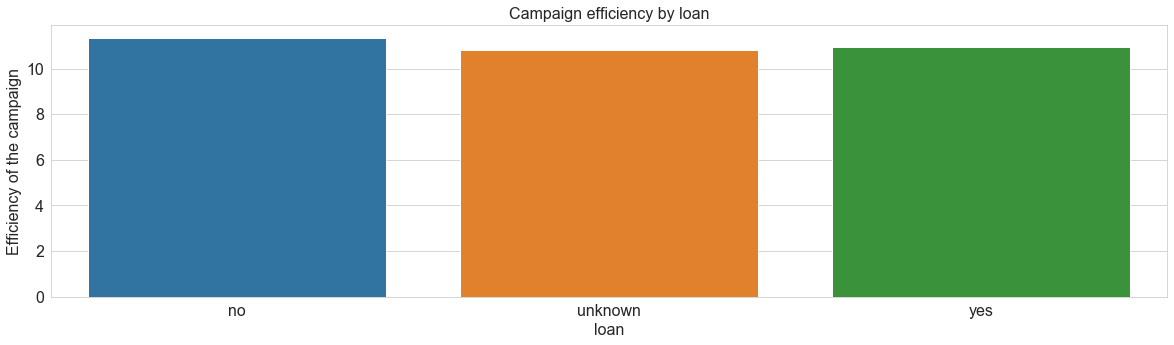

In [6]:
for column in client_data.columns[:-1]:
    #Create an array to store efficiency of eacht
    efficiency = []
    for column_value in np.sort(client_data[column].unique()):
        efficiency.append(client_data.loc[(client_data.y == 'yes') & (client_data[column] == column_value)][column].count() / client_data.loc[client_data[column] == column_value][column].count() * 100) 

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)

    sns.barplot(x=np.sort(client_data[column].unique()), y=efficiency)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Efficiency of the campaign', fontsize=16)
    ax.set_title("Campaign efficiency by " + column, fontsize=16)
    ax.tick_params(labelsize=16)

* It is clear that clients that are younger than 23 and older than 60 are more likely to subscribe on term deposits. Same pattern can be seen on the 'efficiency' graph, where 'students' and 'retired' have the highest values.
* 'Unemployed' and 'administrators' have higher efficiencies and need to be explored more deeply.
* 'Single' clients have a slightly higher efficiency than 'married' and 'divorced'. 
* 'Illiterate' have the highest efficiency but thier number is too miniscule to consider.
* 'University graduates' have slightly higher efficiency than others.
* No correlation was spotted among other variables.

### Insights Client Data
* Majority of bank clients is in the age between 31 and 36 years
* Clients over 60  and under 23 are 3-4 times more willing to subscribe for term deposits than average client.

## 2. Understanding Current Campaign data

In [7]:
#Selecting current campaign related columns
campaign_data = data.iloc[:, 7:12]
#Adding 'y'
campaign_data = pd.concat([campaign_data, data.y], axis = 1)
campaign_data.head()

contact month day_of_week  duration  campaign   y
0  telephone   may         mon       261         1  no
1  telephone   may         mon       149         1  no
2  telephone   may         mon       226         1  no
3  telephone   may         mon       151         1  no
4  telephone   may         mon       307         1  no

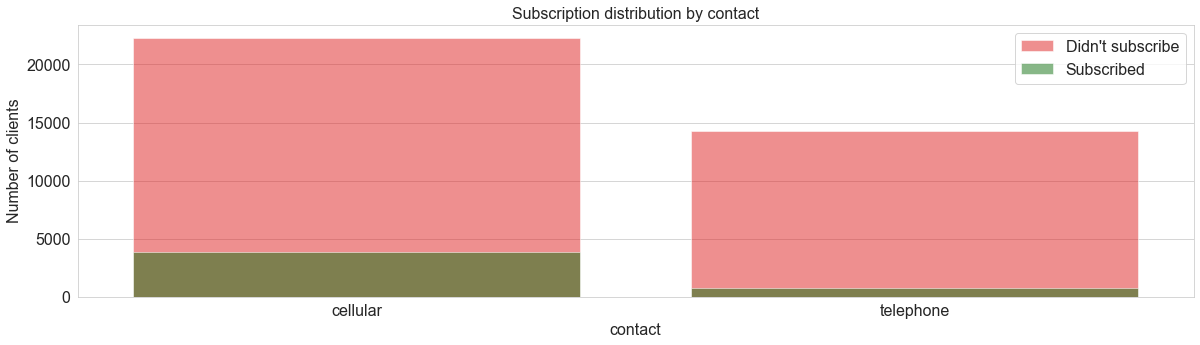

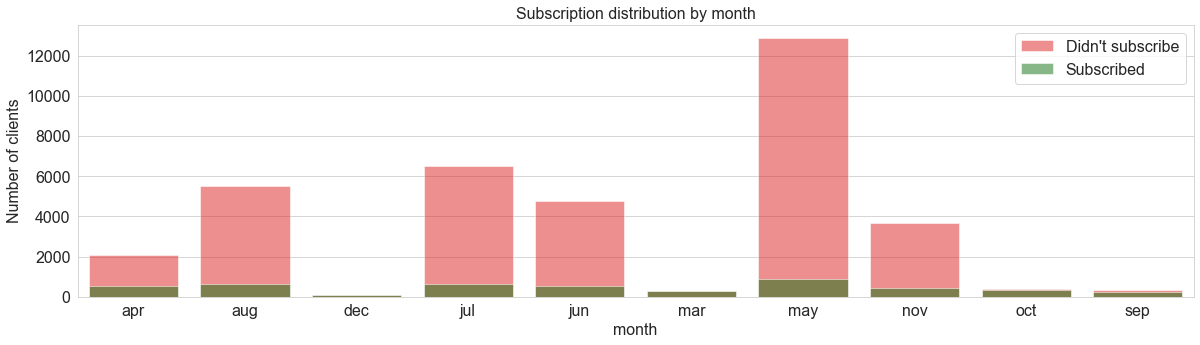

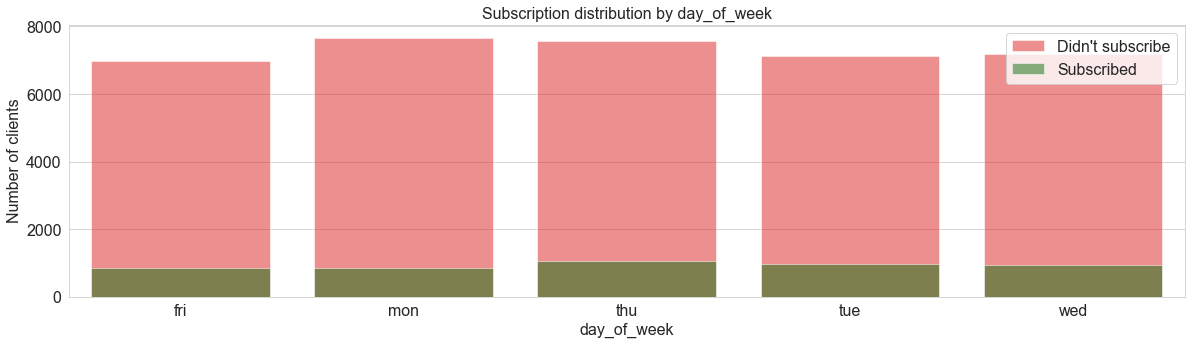

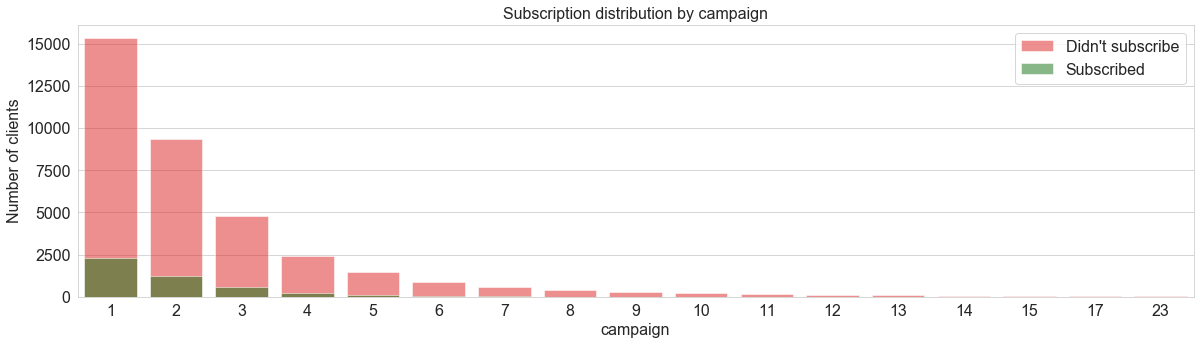

In [8]:
sns.set_style("whitegrid")
for column in campaign_data.drop(['duration'], axis = 1).columns[:-1]:
    #Comparing subscribtion composition of each variable
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    sns.countplot(x = column, data = campaign_data[campaign_data.y == 'no'].sort_values(by = [column]), label="Didn't subscribe", color = 'red', alpha = 0.5)
    sns.countplot(x = column, data = campaign_data[campaign_data.y == 'yes'].sort_values(by = [column]), label="Subscribed", color = 'green', alpha = 0.5)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Number of clients', fontsize=16)
    ax.set_title("Subscription distribution by " + column, fontsize=16)
    ax.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    plt.show()

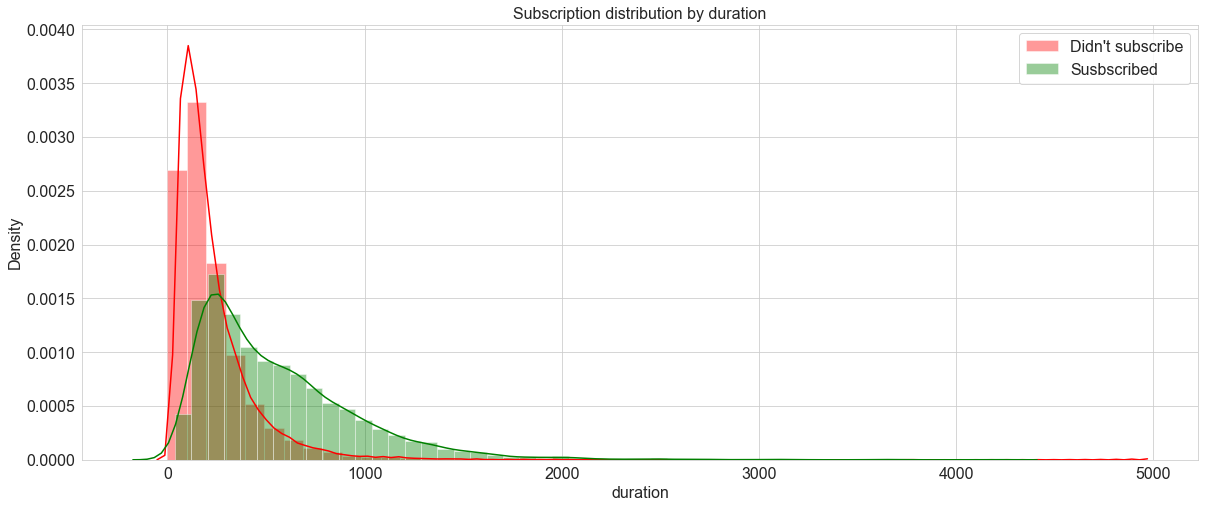

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
    
sns.distplot(a=campaign_data[campaign_data.y == 'no']['duration'], label="Didn't subscribe", color = 'red')
sns.distplot(a=campaign_data[campaign_data.y == 'yes']['duration'], label="Susbscribed", color = 'green')

ax.set_xlabel('duration', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Subscription distribution by duration", fontsize=16)
ax.tick_params(labelsize=16)
plt.legend(fontsize=16)
plt.show()

**We can see that the longer duration of the call the higher chance of client subscribing to term deposit.**

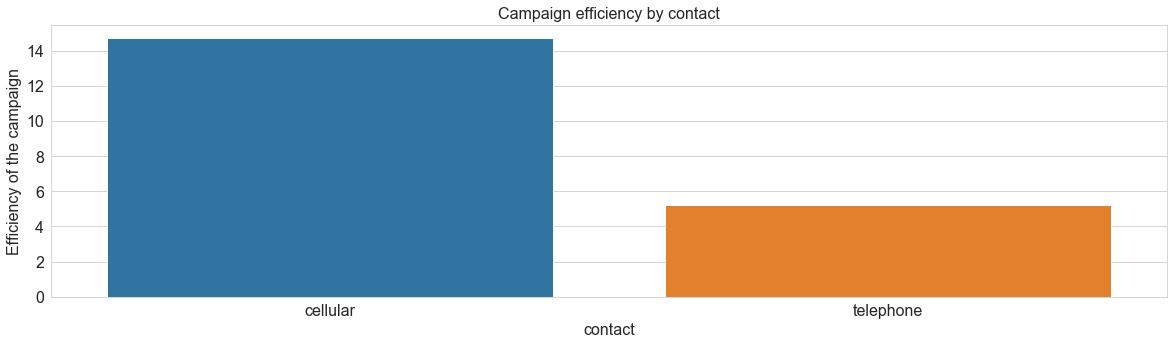

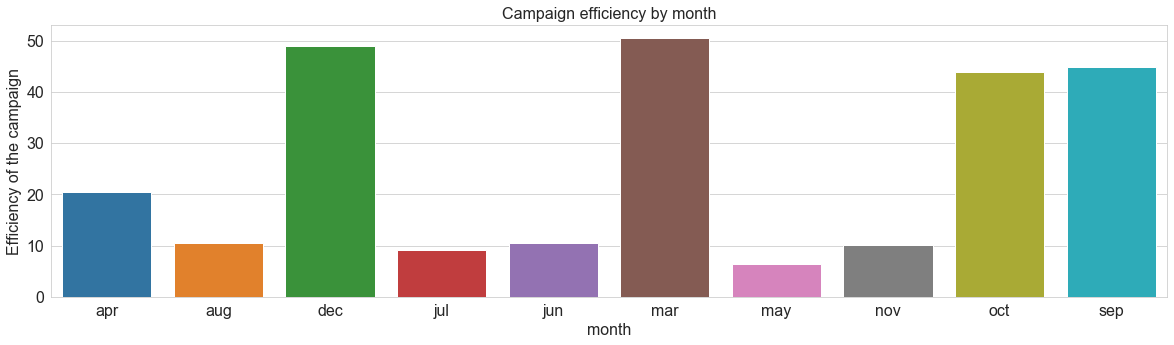

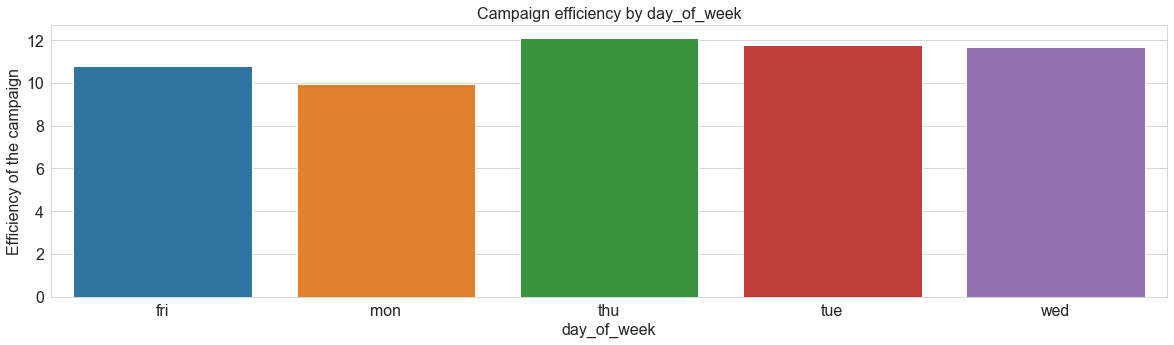

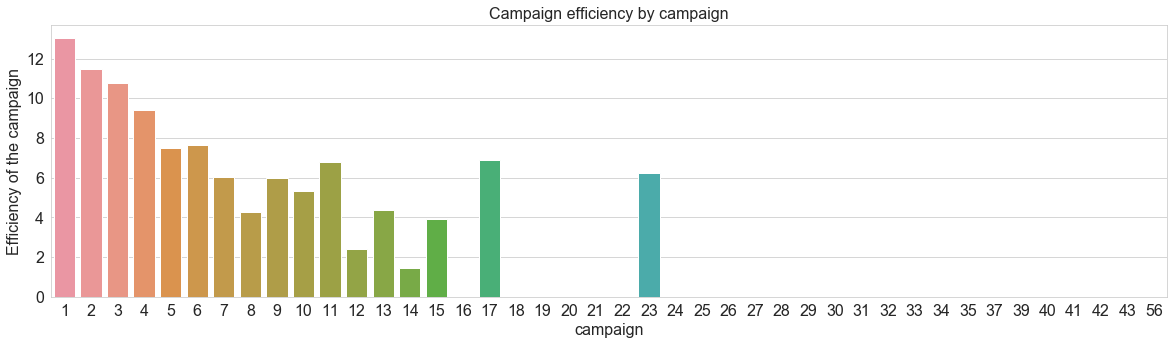

In [10]:
for column in campaign_data.drop(['duration'], axis = 1).columns[:-1]:
    #Create an array to store efficiency of each variable
    efficiency = []
    for column_value in np.sort(campaign_data[column].unique()):
        efficiency.append(campaign_data.loc[(campaign_data.y == 'yes') & (campaign_data[column] == column_value)][column].count() / campaign_data.loc[campaign_data[column] == column_value][column].count() * 100) 

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)

    sns.barplot(x=np.sort(campaign_data[column].unique()), y=efficiency)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Efficiency of the campaign', fontsize=16)
    ax.set_title("Campaign efficiency by " + column, fontsize=16)
    ax.tick_params(labelsize=16)

**No useful information regarding months and days of the week. But it is good to know that calling to cellular is 3 times more efficient than calling to telephone.**

**Let's plot cumulative efficiency of the campaign to understand when to stop calling.**

[13.037070626913048,
 23.00037313124685,
 32.51613958121343,
 40.899385251755916,
 47.69918397544898,
 54.78513721103225,
 60.36365329847101,
 64.35689654171425,
 70.10866332616655,
 75.12161974548339,
 81.53969884152858,
 83.7769869771218,
 88.02046523799136,
 89.40672862803547,
 93.27146292755238,
 93.27146292755238,
 100.1680146516903,
 100.1680146516903,
 100.1680146516903,
 100.1680146516903,
 100.1680146516903,
 100.1680146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903,
 106.4180146516903]

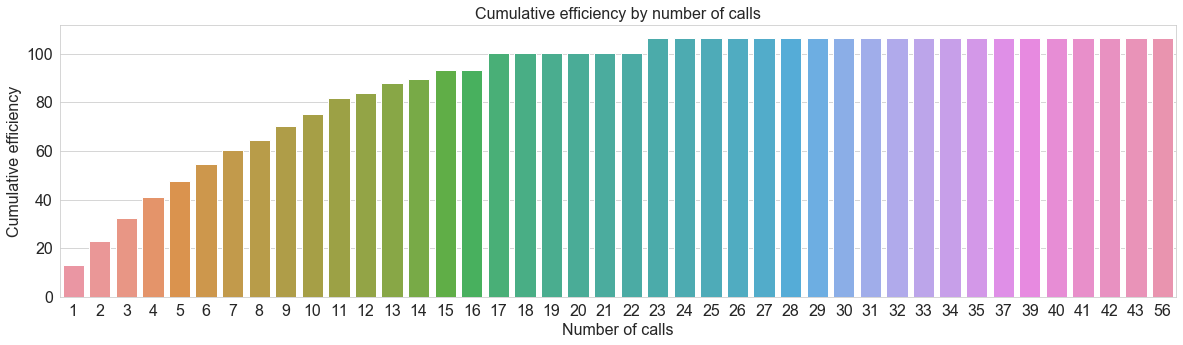

In [11]:
cumulative_efficiency = [0]
efficiency = [0]
for column_value in np.sort(campaign_data[column].unique()):
    cumulative_efficiency.append(cumulative_efficiency[-1] + (1 - efficiency[-1]) * campaign_data.loc[(campaign_data.y == 'yes') & (campaign_data['campaign'] == column_value)]['campaign'].count() / campaign_data.loc[campaign_data['campaign'] == column_value]['campaign'].count())
    efficiency.append(campaign_data.loc[(campaign_data.y == 'yes') & (campaign_data['campaign'] == column_value)]['campaign'].count() / campaign_data.loc[campaign_data['campaign'] == column_value]['campaign'].count())     
    
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)

cumulative_efficiency.pop(0)
cumulative_efficiency = [i * 100 for i in cumulative_efficiency]
sns.barplot(x=np.sort(campaign_data['campaign'].unique()), y=cumulative_efficiency)

ax.set_xlabel('Number of calls', fontsize=16)
ax.set_ylabel('Cumulative efficiency', fontsize=16)
ax.set_title("Cumulative efficiency by number of calls", fontsize=16)
ax.tick_params(labelsize=16)

cumulative_efficiency
#Percentages that higher than 100 is the result of calculation approach

**So bank needs to call at least 15 times to cover 93% of all clients that will subscribe to term deposit.**

### Insights Campaign Data
* It is 3 times more efficient to call to cellular number (15% efficiency) than to telephone number (5% efficiency).
* The longer the duration of the call the higher chance of client subscribing.
* To cover 93% of all clients that might subscribe to the term deposit, the minimum of 15 calls is required.

## 3. Understanding Previous Campaign data

In [12]:
#Selecting previous campaign related columns
pcampaign_data = data.iloc[:, 12:15]
#Adding 'y'
pcampaign_data = pd.concat([pcampaign_data, data.y], axis = 1)
pcampaign_data.head()

pdays  previous     poutcome   y
0    999         0  nonexistent  no
1    999         0  nonexistent  no
2    999         0  nonexistent  no
3    999         0  nonexistent  no
4    999         0  nonexistent  no

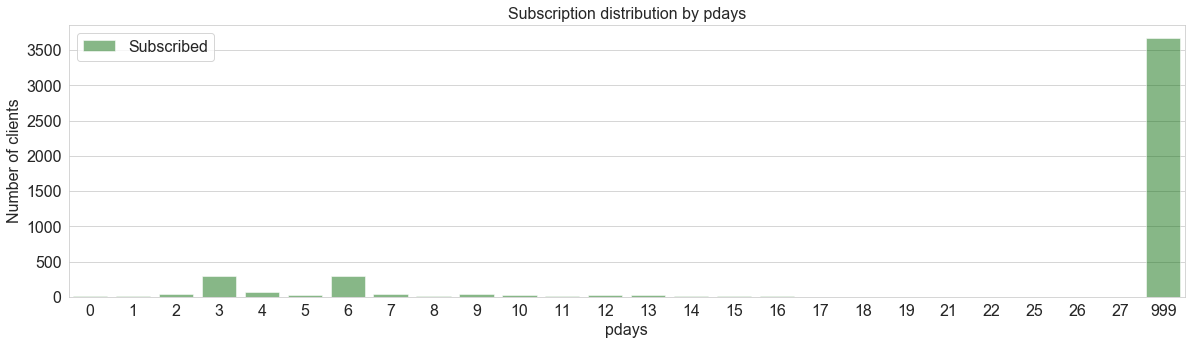

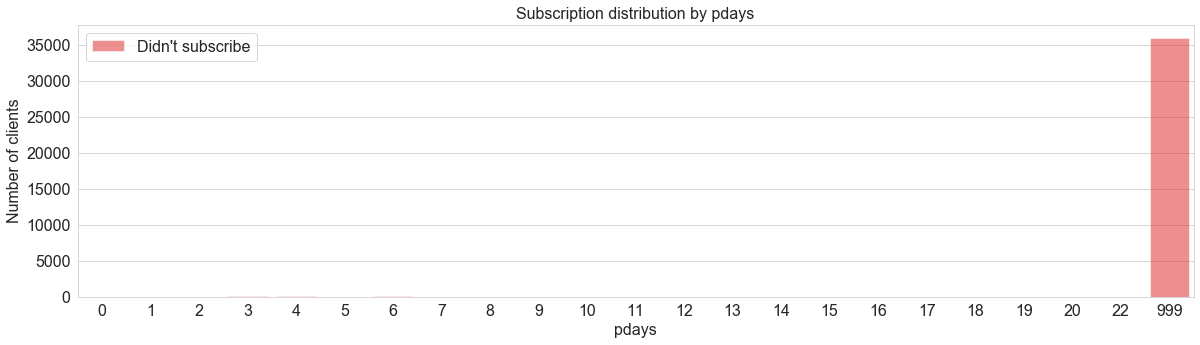

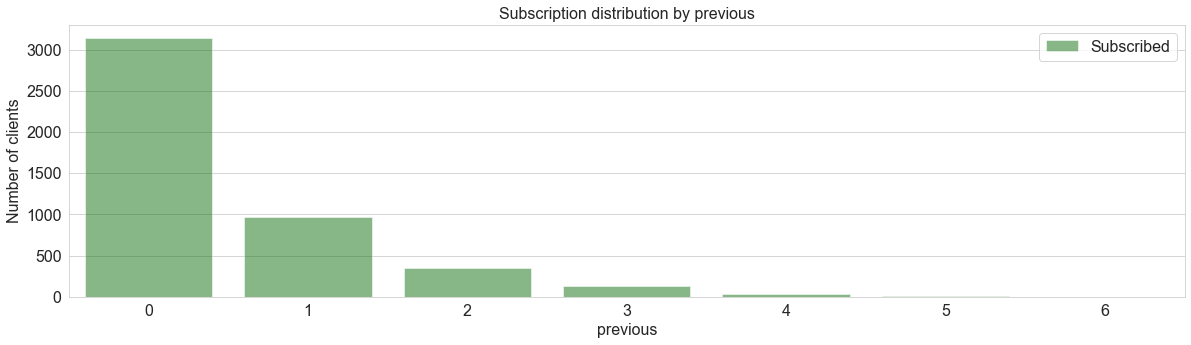

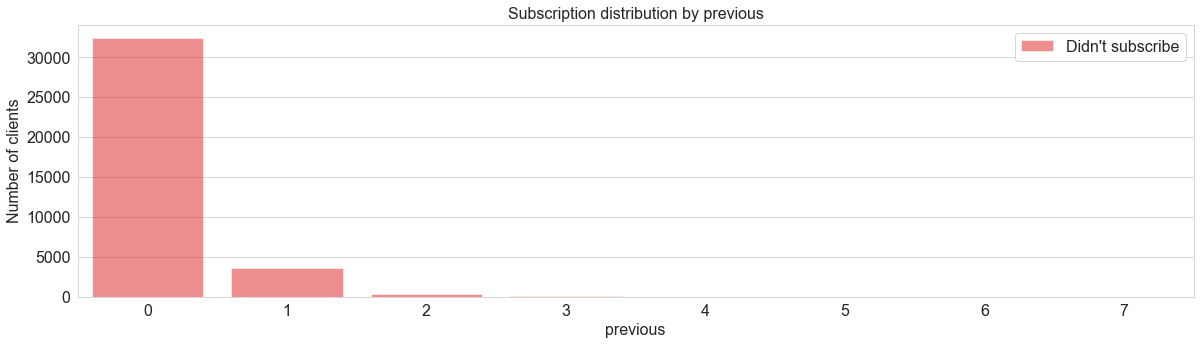

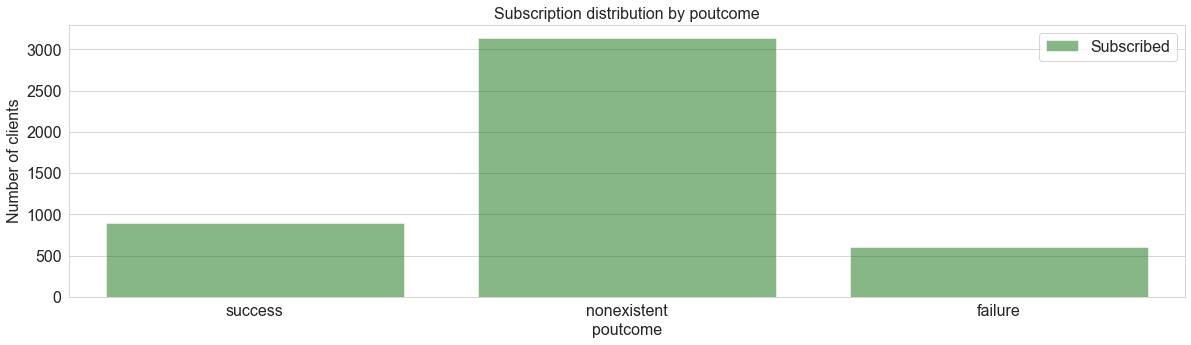

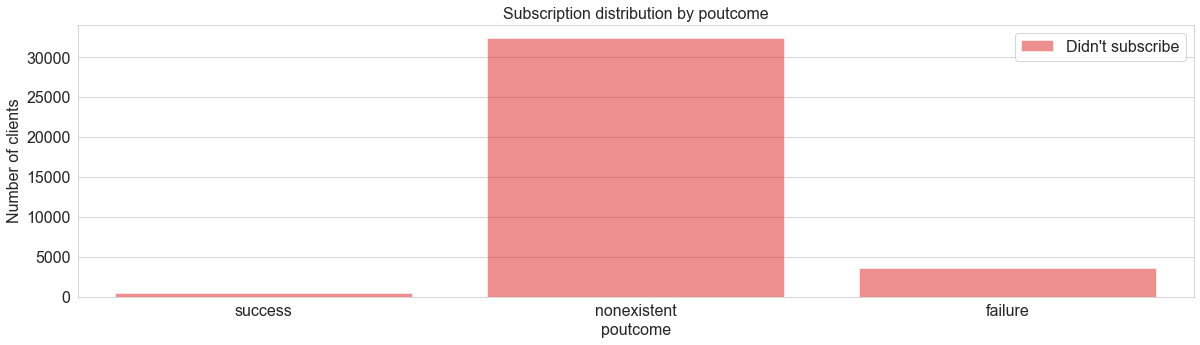

In [13]:
sns.set_style("whitegrid")
for column in pcampaign_data.columns[:-1]:
    #Comparing subscribtion composition of each variable
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    
    sns.countplot(x = column, data = pcampaign_data.sort_values(by = [column], ascending = False)[pcampaign_data.y == 'yes'], label="Subscribed", color = 'green', alpha = 0.5)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Number of clients', fontsize=16)
    ax.set_title("Subscription distribution by " + column, fontsize=16)
    ax.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    plt.show()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    sns.countplot(x = column, data = pcampaign_data.sort_values(by = [column], ascending = False)[pcampaign_data.y == 'no'], label="Didn't subscribe", color = 'red', alpha = 0.5)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Number of clients', fontsize=16)
    ax.set_title("Subscription distribution by " + column, fontsize=16)
    ax.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    plt.show()

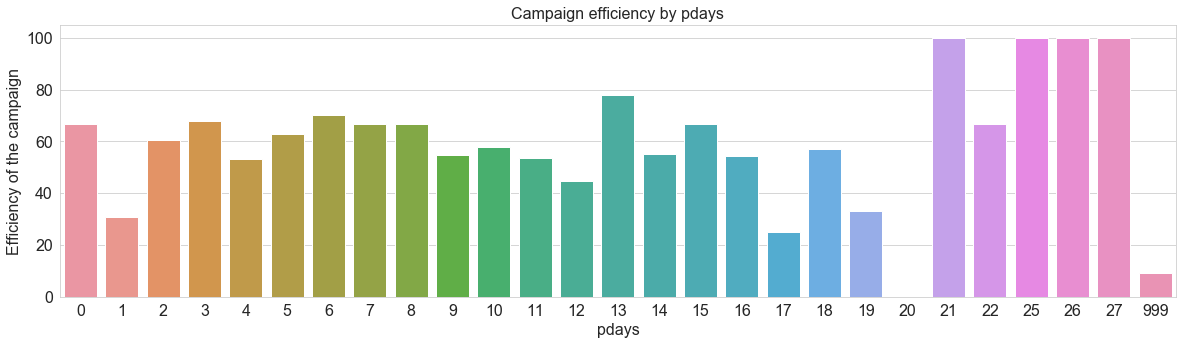

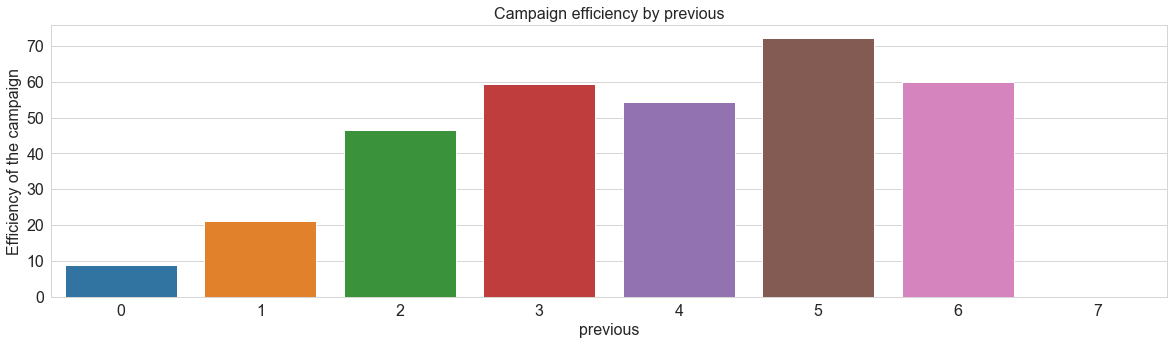

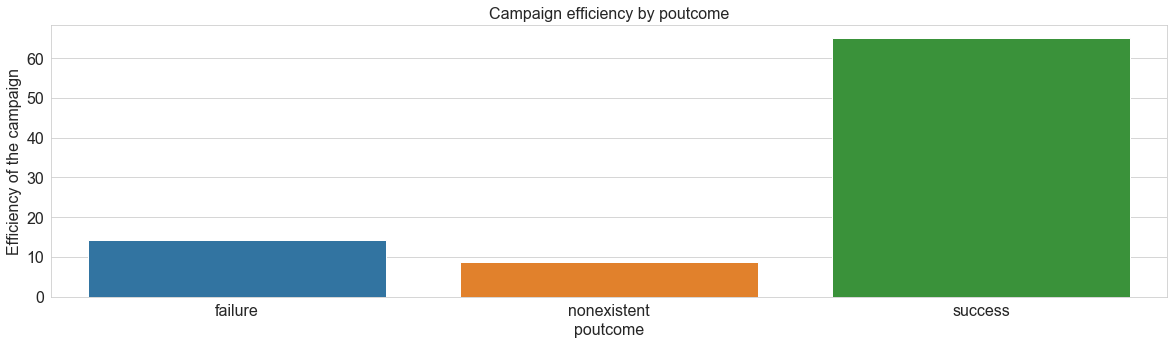

In [14]:
for column in pcampaign_data.columns[:-1]:
    #Create an array to store efficiency of each variable
    efficiency = []
    for column_value in np.sort(pcampaign_data[column].unique()):
        efficiency.append(pcampaign_data.loc[(pcampaign_data.y == 'yes') & (pcampaign_data[column] == column_value)][column].count() / pcampaign_data.loc[pcampaign_data[column] == column_value][column].count() * 100) 

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)

    sns.barplot(x=np.sort(pcampaign_data[column].unique()), y=efficiency)

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Efficiency of the campaign', fontsize=16)
    ax.set_title("Campaign efficiency by " + column, fontsize=16)
    ax.tick_params(labelsize=16)

**We got expected results. Clients that have been contacted in the previous campaign has higher efficiencty. Moreover, clients that subscribed for previous campaign offer are 3 times more likely to subscribe for term deposit than those who rejected previous offer.**

### Insights Previous Campaign Data
* If client was contacted at least once in the previous campaign, the chance of client subscribing is higher.
* Clients that subscribed for previous campaign offer are 3 times more likely to subscribe for term deposit than those who rejected previous offer.

## 4. Understanding Social and Economic context attributes

In [15]:
#Selecting Social and Economic context attributes related columns
attr_data = data.iloc[:, 15:]

attr_data.head()

emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y
0           1.1          93.994          -36.4      4.857       5191.0  no
1           1.1          93.994          -36.4      4.857       5191.0  no
2           1.1          93.994          -36.4      4.857       5191.0  no
3           1.1          93.994          -36.4      4.857       5191.0  no
4           1.1          93.994          -36.4      4.857       5191.0  no

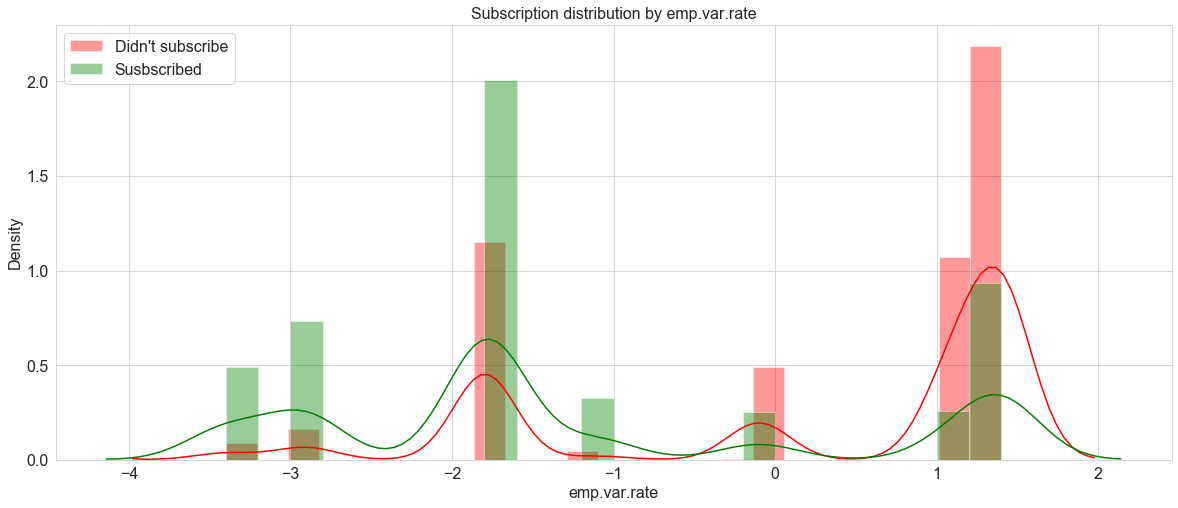

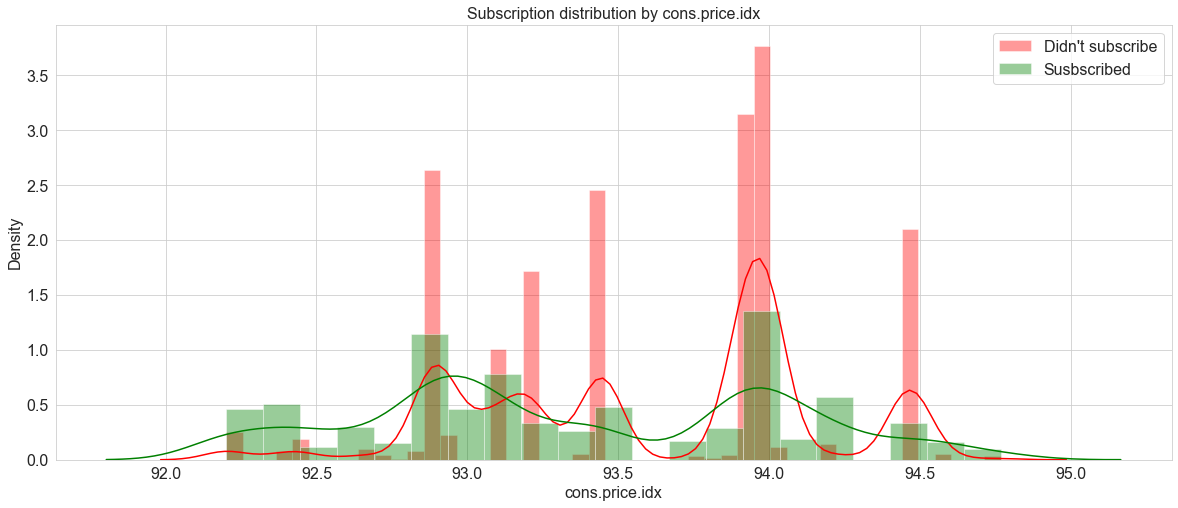

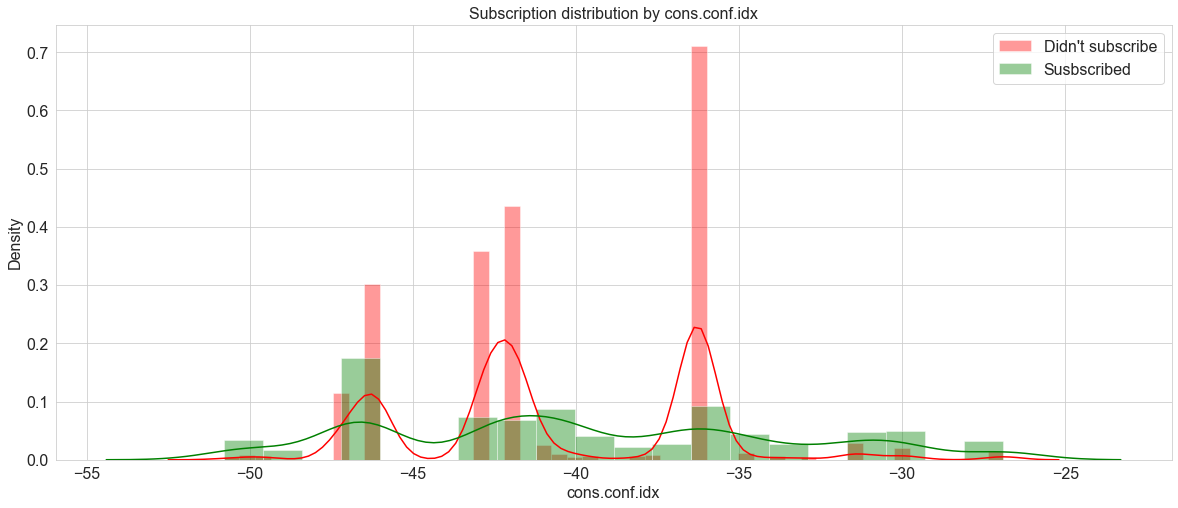

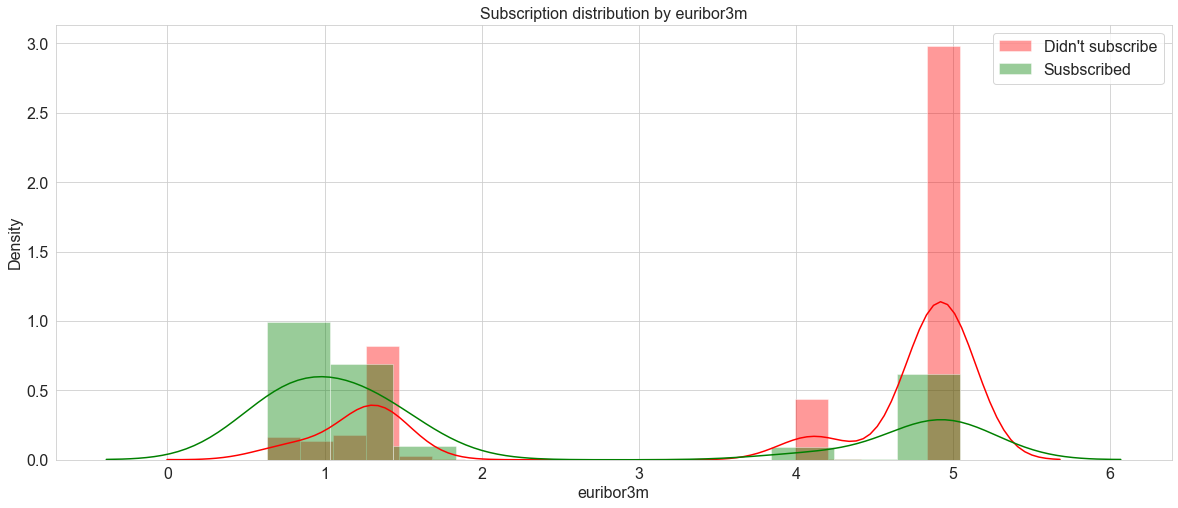

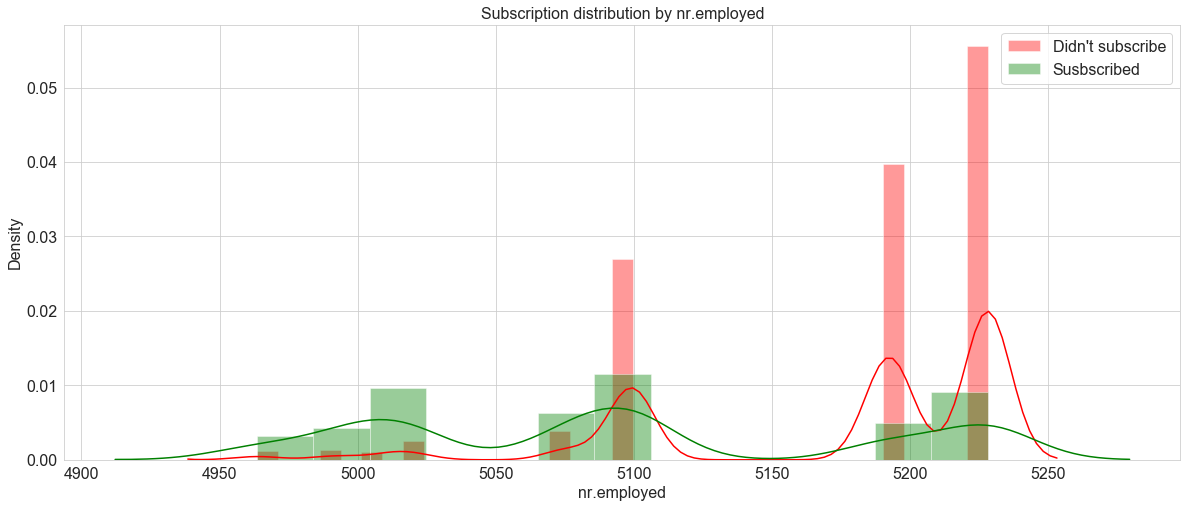

In [16]:
for column in attr_data.columns[:-1]:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    
    sns.distplot(a=attr_data[campaign_data.y == 'no'][column], label="Didn't subscribe", color = 'red')
    sns.distplot(a=attr_data[campaign_data.y == 'yes'][column], label="Susbscribed", color = 'green')

    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    ax.set_title("Subscription distribution by " + column, fontsize=16)
    ax.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    plt.show()

### Insights Social and Economic context attributes
* If employment variation rate is lower than 0, probabilty of subscriving for term deposit is higher.
* If consumer price index is lower than 93.5, probabilty of subscriving for term deposit is higher.
* If consumer price index is lower than -47.5 and higher than -35, probabilty of subscriving for term deposit is higher.
* If euribor 3 month rate is lower than 3, probabilty of subscriving for term deposit is higher.
* If number of employees is lower than 5150, probabilty of subscriving for term deposit is higher.

# Model building
## Prepocessing
### Missing values
In the dataset all missing values were changed to "Unknown". Let's find out what percentage of data is missing to decide dropping columns or rather imputing missing values. 


In [17]:
print('Percentage of missing values by column: \n', data.replace('unknown', np.nan).isna().sum()/data.count() *100)

Percentage of missing values by column: 
 age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64


Column 'default' has the most percentage of missing values, but generally all clients don't have default (only 3 clients have), so we can drop this column because it doesn't convey useful information.

### Preprocessing and cross validation pipeline
I will start with building baseline model of logistic regression and pipeline for preprocessing and cros validation.

In [18]:
data = data.replace('unknown', np.nan)

X = data.drop(['y'], axis = 1).drop(['default'], axis = 1)

y = data.y.map(dict(yes=1, no=0))

X, y = shuffle(X, y, random_state = 0)


numerical_cols = [cname for cname in data.columns if data[cname].dtype in ['int64', 'float64']]

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


model = LogisticRegression(C=1, penalty="l2")

# Bundle preprocessing and modeling code in a pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)
                             ])

scores = cross_val_score(model_pipeline, X, y,
                              cv=5,
                              scoring='accuracy')

In [19]:
scores.mean() #1 is the best result, 0 is the worst result

0.9110663509057642

## Better model

## Feature Engineering
### Count encoding

In [20]:
import category_encoders as ce

# Create the count encoder
count_enc = ce.CountEncoder(cols=categorical_cols)

# Learn encoding from the training set
count_enc.fit(X[categorical_cols])

X_ce = X.join(count_enc.transform(X[categorical_cols]).add_suffix("_count")) 



# Reinitializing numerical columns
numerical_cols = [cname for cname in X_ce.columns if X_ce[cname].dtype in ['int64', 'float64']]

# Reinitialzing transformer with new columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Reinitialzing preprocessor
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)
                             ])

scores = cross_val_score(model_pipeline, X_ce, y,
                              cv=5,
                              scoring='accuracy')

In [21]:
scores.mean() #1 is the best result, 0 is the worst result

0.9109449592717894

### Target encoding

In [22]:
# Create the encoder itself
target_enc = ce.TargetEncoder(cols=categorical_cols)

# Fit the encoder using the categorical features and target
target_enc.fit(X[categorical_cols], y)

# Transform the features, rename the columns with _target suffix, and join to dataframe
X_tar = X.join(target_enc.transform(X[categorical_cols]).add_suffix("_target")) 


# Reinitializing numerical columns
numerical_cols = [cname for cname in X_tar.columns if X_tar[cname].dtype in ['int64', 'float64']]

# Reinitialzing transformer with new columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Reinitialzing preprocessor
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)
                             ])

scores = cross_val_score(model_pipeline, X_tar, y,
                              cv=5,
                              scoring='accuracy')

In [23]:
scores.mean() #1 is the best result, 0 is the worst result

0.9108963979023587

### CatBoost Encoding

In [31]:
target_enc = ce.CatBoostEncoder(cols=categorical_cols)

target_enc.fit(X[categorical_cols], y)


# Transform the features, rename the columns with _target suffix, and join to dataframe
X_cb = X.join(target_enc.transform(X[categorical_cols]).add_suffix("_cb")) 


# Reinitializing numerical columns
numerical_cols = [cname for cname in X_cb.columns if X_cb[cname].dtype in ['int64', 'float64']]

# Reinitialzing transformer with new columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Reinitialzing preprocessor
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)
                             ])

scores = cross_val_score(model_pipeline, X_cb, y,
                              cv=5,
                              scoring='accuracy')

In [32]:
scores.mean() #1 is the best result, 0 is the worst result

0.9108235617430136

### Interactions

In [45]:
import itertools

categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
interactions = pd.DataFrame(index=data.index)

# Iterate through each pair of features, combine them into interaction features
for col1, col2 in itertools.combinations(categorical_cols, 2):
        new_col_name = '_'.join([col1, col2])

        # Convert to strings and combine
        new_values = data[col1].map(str) + "_" + data[col2].map(str)

        interactions[new_col_name] = new_values
X_inter = pd.concat([X, interactions], axis = 1)


# Reinitializing numerical columns
numerical_cols = [cname for cname in X_inter.columns if X_inter[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X_inter.columns if X_inter[cname].dtype == "object"]

# Reinitialzing transformer with new columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Reinitialzing preprocessor
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)
                             ])

scores = cross_val_score(model_pipeline, X_inter, y,
                              cv=5,
                              scoring='accuracy')

In [47]:
scores.mean() #1 is the best result, 0 is the worst result

0.8863017973572017

In [39]:
categorical_cols

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'job_marital',
 'job_education',
 'job_housing',
 'job_loan',
 'job_contact',
 'job_month',
 'job_day_of_week',
 'job_poutcome',
 'marital_education',
 'marital_housing',
 'marital_loan',
 'marital_contact',
 'marital_month',
 'marital_day_of_week',
 'marital_poutcome',
 'education_housing',
 'education_loan',
 'education_contact',
 'education_month',
 'education_day_of_week',
 'education_poutcome',
 'housing_loan',
 'housing_contact',
 'housing_month',
 'housing_day_of_week',
 'housing_poutcome',
 'loan_contact',
 'loan_month',
 'loan_day_of_week',
 'loan_poutcome',
 'contact_month',
 'contact_day_of_week',
 'contact_poutcome',
 'month_day_of_week',
 'month_poutcome',
 'day_of_week_poutcome']